## Model training and batch inference on test data to find the test accuracy.

### The model used for the sentence simillarity task is of Bert. The bert model will be retrained using tensorflow in this notebook.

## Downloading the dataset

In [13]:
%%writefile data_download.py

''' Script for downloading all GLUE data.
Note: for legal reasons, we are unable to host MRPC.
You can either use the version hosted by the SentEval team, which is already tokenized, 
or you can download the original data from (https://download.microsoft.com/download/D/4/6/D46FF87A-F6B9-4252-AA8B-3604ED519838/MSRParaphraseCorpus.msi) and extract the data from it manually.
For Windows users, you can run the .msi file. For Mac and Linux users, consider an external library such as 'cabextract' (see below for an example).
You should then rename and place specific files in a folder (see below for an example).
mkdir MRPC
cabextract MSRParaphraseCorpus.msi -d MRPC
cat MRPC/_2DEC3DBE877E4DB192D17C0256E90F1D | tr -d $'\r' > MRPC/msr_paraphrase_train.txt
cat MRPC/_D7B391F9EAFF4B1B8BCE8F21B20B1B61 | tr -d $'\r' > MRPC/msr_paraphrase_test.txt
rm MRPC/_*
rm MSRParaphraseCorpus.msi
1/30/19: It looks like SentEval is no longer hosting their extracted and tokenized MRPC data, so you'll need to download the data from the original source for now.
2/11/19: It looks like SentEval actually *is* hosting the extracted data. Hooray!
'''

import io
import os
import sys
import shutil
import argparse
import tempfile
import urllib
import urllib.request
import zipfile

TASKS = ["CoLA", "SST", "MRPC", "QQP", "STS", "MNLI", "QNLI", "RTE", "WNLI", "diagnostic", "MRPC"]
TASK2PATH = {"CoLA":'https://dl.fbaipublicfiles.com/glue/data/CoLA.zip',
             "SST":'https://dl.fbaipublicfiles.com/glue/data/SST-2.zip',
             "QQP":'https://dl.fbaipublicfiles.com/glue/data/STS-B.zip',
             "STS":'https://dl.fbaipublicfiles.com/glue/data/QQP-clean.zip',
             "MNLI":'https://dl.fbaipublicfiles.com/glue/data/MNLI.zip',
             "QNLI":'https://dl.fbaipublicfiles.com/glue/data/QNLIv2.zip',
             "RTE":'https://dl.fbaipublicfiles.com/glue/data/RTE.zip',
             "WNLI":'https://dl.fbaipublicfiles.com/glue/data/WNLI.zip',
             "diagnostic":'https://dl.fbaipublicfiles.com/glue/data/AX.tsv',
             "MRPC": "https://raw.githubusercontent.com/MegEngine/Models/master/official/nlp/bert/glue_data/MRPC/dev_ids.tsv"}

MRPC_TRAIN = 'https://dl.fbaipublicfiles.com/senteval/senteval_data/msr_paraphrase_train.txt'
MRPC_TEST = 'https://dl.fbaipublicfiles.com/senteval/senteval_data/msr_paraphrase_test.txt'

def download_and_extract(task, data_dir):
    print("Downloading and extracting %s..." % task)
    if task == "MNLI":
        print("\tNote (12/10/20): This script no longer downloads SNLI. You will need to manually download and format the data to use SNLI.")
    data_file = "%s.zip" % task
    urllib.request.urlretrieve(TASK2PATH[task], data_file)
    with zipfile.ZipFile(data_file) as zip_ref:
        zip_ref.extractall(data_dir)
    os.remove(data_file)
    print("\tCompleted!")

def format_mrpc(data_dir, path_to_data):
    print("Processing MRPC...")
    mrpc_dir = os.path.join(data_dir, "MRPC")
    if not os.path.isdir(mrpc_dir):
        os.mkdir(mrpc_dir)
    if path_to_data:
        mrpc_train_file = os.path.join(path_to_data, "msr_paraphrase_train.txt")
        mrpc_test_file = os.path.join(path_to_data, "msr_paraphrase_test.txt")
    else:
        try:
            mrpc_train_file = os.path.join(mrpc_dir, "msr_paraphrase_train.txt")
            mrpc_test_file = os.path.join(mrpc_dir, "msr_paraphrase_test.txt")
            urllib.request.urlretrieve(MRPC_TRAIN, mrpc_train_file)
            urllib.request.urlretrieve(MRPC_TEST, mrpc_test_file)
        except urllib.error.HTTPError:
            print("Error downloading MRPC")
            return
    assert os.path.isfile(mrpc_train_file), "Train data not found at %s" % mrpc_train_file
    assert os.path.isfile(mrpc_test_file), "Test data not found at %s" % mrpc_test_file

    with io.open(mrpc_test_file, encoding='utf-8') as data_fh, \
            io.open(os.path.join(mrpc_dir, "test.tsv"), 'w', encoding='utf-8') as test_fh:
        header = data_fh.readline()
        test_fh.write("index\t#1 ID\t#2 ID\t#1 String\t#2 String\n")
        for idx, row in enumerate(data_fh):
            label, id1, id2, s1, s2 = row.strip().split('\t')
            test_fh.write("%d\t%s\t%s\t%s\t%s\n" % (idx, id1, id2, s1, s2))

    try:
        urllib.request.urlretrieve(TASK2PATH["MRPC"], os.path.join(mrpc_dir, "dev_ids.tsv"))
    except KeyError or urllib.error.HTTPError:
        print("\tError downloading standard development IDs for MRPC. You will need to manually split your data.")
        return

    dev_ids = []
    with io.open(os.path.join(mrpc_dir, "dev_ids.tsv"), encoding='utf-8') as ids_fh:
        for row in ids_fh:
            dev_ids.append(row.strip().split('\t'))

    with io.open(mrpc_train_file, encoding='utf-8') as data_fh, \
         io.open(os.path.join(mrpc_dir, "train.tsv"), 'w', encoding='utf-8') as train_fh, \
         io.open(os.path.join(mrpc_dir, "dev.tsv"), 'w', encoding='utf-8') as dev_fh:
        header = data_fh.readline()
        train_fh.write(header)
        dev_fh.write(header)
        for row in data_fh:
            label, id1, id2, s1, s2 = row.strip().split('\t')
            if [id1, id2] in dev_ids:
                dev_fh.write("%s\t%s\t%s\t%s\t%s\n" % (label, id1, id2, s1, s2))
            else:
                train_fh.write("%s\t%s\t%s\t%s\t%s\n" % (label, id1, id2, s1, s2))
                
    print("\tCompleted!")
    
def download_diagnostic(data_dir):
    print("Downloading and extracting diagnostic...")
    if not os.path.isdir(os.path.join(data_dir, "diagnostic")):
        os.mkdir(os.path.join(data_dir, "diagnostic"))
    data_file = os.path.join(data_dir, "diagnostic", "diagnostic.tsv")
    urllib.request.urlretrieve(TASK2PATH["diagnostic"], data_file)
    print("\tCompleted!")
    return

def get_tasks(task_names):
    task_names = task_names.split(',')
    if "all" in task_names:
        tasks = TASKS
    else:
        tasks = []
        for task_name in task_names:
            assert task_name in TASKS, "Task %s not found!" % task_name
            tasks.append(task_name)
    return tasks

def main(arguments):
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_dir', help='directory to save data to', type=str, default='glue_data')
    parser.add_argument('--tasks', help='tasks to download data for as a comma separated string',
                        type=str, default='all')
    parser.add_argument('--path_to_mrpc', help='path to directory containing extracted MRPC data, msr_paraphrase_train.txt and msr_paraphrase_text.txt',
                        type=str, default='')
    args = parser.parse_args(arguments)

    if not os.path.isdir(args.data_dir):
        os.mkdir(args.data_dir)
    tasks = get_tasks(args.tasks)

    for task in tasks:
        if task == 'MRPC':
            format_mrpc(args.data_dir, args.path_to_mrpc)
        elif task == 'diagnostic':
            download_diagnostic(args.data_dir)
        else:
            download_and_extract(task, args.data_dir)


if __name__ == '__main__':
    sys.exit(main(sys.argv[1:]))

Writing data_download.py


In [ ]:
#saving the dataset to the GDrive
! python /content/data_download.py --data_dir /content/drive/MyDrive/MRPC_Assignment/MRPC_Data --tasks MRPC

Processing MRPC...
	Completed!


## Python Package Installation

In [ ]:
!pip install tensorflow-text
!pip install tf-models-official
#!pip install -q tf-models-nightly
#!pip3 install -q opencv-python-headless==4.1.2.30

In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_models as tfm
import tensorflow_text as text

## Dataset loading and basic EDA

In [9]:
def load_dataset(dir:str):
  df= pd.read_table(dir, on_bad_lines="skip")
  df= df.loc[~df['#2 String'].isnull(),:]
  df.drop(['#1 ID', '#2 ID'], axis=1, inplace=True)
  df.rename(columns = {"Quality" : "label",
                       "#1 String" : "sentence1",
                       "#2 String" : "sentence2"}, 
            inplace=True)
  return df

In [10]:
train_df= load_dataset('/content/drive/MyDrive/MRPC_Assignment/MRPC_Data/MRPC/train.tsv')
dev_df= load_dataset('/content/drive/MyDrive/MRPC_Assignment/MRPC_Data/MRPC/dev.tsv')

In [ ]:
len(train_df)

3529

In [ ]:
print("fraction of train sample for positive class ", round(train_df['label'].mean(),2))
print("fraction of dev sample for positive class ", round(dev_df['label'].mean(),2))

fraction of train sample for positive class  0.67
fraction of dev sample for positive class  0.68


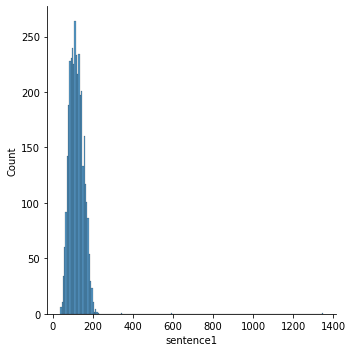

In [ ]:
#checking the number of words for train dataset
sns.displot(train_df['sentence1'].map(lambda x : len(x)))

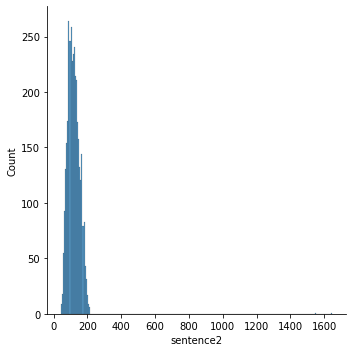

In [ ]:
sns.displot(train_df['sentence2'].map(lambda x : len(x)))

## Data preprocessing for Bert
Model to be used for finetuning is
https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2

In [11]:
os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"

In [12]:
preprocessor = hub.load("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

In [ ]:
sent1= ["my name is khan and I", "she is good"]
sent2= ["give me my name", "that was painful"]
sen1= preprocessor.tokenize(sent1)
sen2= preprocessor.tokenize(sent2)
preprocessor.bert_pack_inputs([sen1,sen2])

In [13]:
max_seq_length= 512
def make_bert_preprocess_model(bert_preprocess_model_tfhub, seq_length=max_seq_length):

  input_segments = [
      tf.keras.layers.Input(shape=(), dtype=tf.string, name="sentence1"),
      tf.keras.layers.Input(shape=(), dtype=tf.string, name="sentence2")      
      ]

  # Tokenize the text to word pieces.
  bert_preprocess = hub.load(bert_preprocess_model_tfhub)
  tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
  segments = [tokenizer(s) for s in input_segments]

  truncated_segments = segments
  # Pack inputs. The details (start/end token ids, dict of output tensors)
  # are model-dependent, so this gets loaded from the SavedModel.
  packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                          arguments=dict(seq_length=seq_length),
                          name='packer')
  model_inputs = packer(truncated_segments)
  return tf.keras.Model(input_segments, model_inputs)

In [14]:
test_preprocess_model= make_bert_preprocess_model("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
test_text = {"sentence1" : np.array(['some random test sentence']),
             "sentence2" : np.array(['another sentence for which'])}
text_preprocessed = test_preprocess_model(test_text)

In [15]:
text_preprocessed

{'input_word_ids': <tf.Tensor: shape=(1, 512), dtype=int32, numpy=
 array([[ 101, 2070, 6721, 3231, 6251,  102, 2178, 6251, 2005, 2029,  102,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0, 

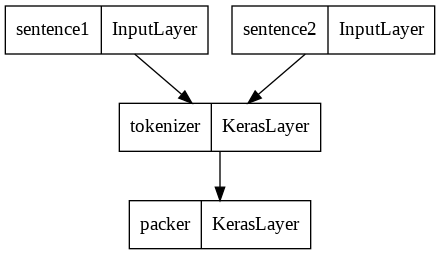

In [16]:
tf.keras.utils.plot_model(test_preprocess_model)

In [17]:
def tsv_tf_dataset(dir:str,shuffle=False, batch_size=32):
  df= pd.read_table(dir, on_bad_lines="skip")
  df= df.loc[~df['#2 String'].isnull(),:]
  df.drop(['#1 ID', '#2 ID'], axis=1, inplace=True)
  df.rename(columns = {"Quality" : "label",
                       "#1 String" : "sentence1",
                       "#2 String" : "sentence2"}, 
            inplace=True)
  
  dataframe = df.copy()
  labels = dataframe.pop('label')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.map(lambda x,y: (test_preprocess_model(x),y))
  ds = ds.prefetch(batch_size)
  return ds

In [18]:
train_ds= tsv_tf_dataset(dir= '/content/drive/MyDrive/MRPC_Assignment/MRPC_Data/MRPC/train.tsv',
                         shuffle=True, batch_size=32)
val_ds= tsv_tf_dataset(dir= '/content/drive/MyDrive/MRPC_Assignment/MRPC_Data/MRPC/dev.tsv',
                         shuffle=False, batch_size=32)

### Model Building

In [19]:
bert_model= "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2"
def build_classifier_model(num_classes):

  class Classifier(tf.keras.Model):
    def __init__(self, num_classes):
      super(Classifier, self).__init__(name="prediction")
      self.encoder = hub.KerasLayer(bert_model, trainable=True)
      self.dropout = tf.keras.layers.Dropout(0.1)
      self.dense = tf.keras.layers.Dense(num_classes, activation="softmax")

    def call(self, preprocessed_text):
      encoder_outputs = self.encoder(preprocessed_text)
      pooled_output = encoder_outputs["pooled_output"]
      x = self.dropout(pooled_output)
      x = self.dense(x)
      return x

  model = Classifier(num_classes)
  return model

In [20]:
test_classifier_model = build_classifier_model(2)

In [21]:
bert_raw_result = test_classifier_model(text_preprocessed)

In [22]:
bert_raw_result

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.44815347, 0.5518465 ]], dtype=float32)>

In [23]:
test_classifier_model.summary()

Model: "prediction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    multiple                  4385921   
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  258       
                                                                 
Total params: 4,386,179
Trainable params: 4,386,178
Non-trainable params: 1
_________________________________________________________________


### Model Training

In [24]:
epochs = 5
batch_size = 32
eval_batch_size = 32

train_data_size = len(train_df)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(0.1 * num_train_steps)
initial_learning_rate=2e-5

In [25]:
linear_decay = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    end_learning_rate=0,
    decay_steps=num_train_steps)

In [26]:
warmup_schedule = tfm.optimization.lr_schedule.LinearWarmup(
    warmup_learning_rate = 0,
    after_warmup_lr_sched = linear_decay,
    warmup_steps = warmup_steps
)

In [27]:
optimizer = tf.keras.optimizers.experimental.Adam(
    learning_rate = warmup_schedule)

In [28]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy()

test_classifier_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

In [29]:
test_classifier_model.fit(
    train_ds,
    validation_data=(val_ds),
    batch_size=16,
    epochs=epochs)

Epoch 1/5
111/111 [==============================] - 30s 185ms/step - loss: 0.8457 - accuracy: 0.5217 - val_loss: 0.6245 - val_accuracy: 0.6718
Epoch 2/5
111/111 [==============================] - 14s 124ms/step - loss: 0.6488 - accuracy: 0.6441 - val_loss: 0.5982 - val_accuracy: 0.6899
Epoch 3/5
111/111 [==============================] - 12s 108ms/step - loss: 0.6247 - accuracy: 0.6659 - val_loss: 0.5890 - val_accuracy: 0.6899
Epoch 4/5
111/111 [==============================] - 11s 96ms/step - loss: 0.6100 - accuracy: 0.6727 - val_loss: 0.5843 - val_accuracy: 0.7003
Epoch 5/5
111/111 [==============================] - 11s 100ms/step - loss: 0.6049 - accuracy: 0.6886 - val_loss: 0.5831 - val_accuracy: 0.7003


## Model Export

In [30]:
class ExportModel(tf.Module):
  def __init__(self, input_processor, classifier):
    self.input_processor = input_processor
    self.classifier = classifier

  @tf.function(input_signature=[{
      'sentence1': tf.TensorSpec(shape=[None], dtype=tf.string),
      'sentence2': tf.TensorSpec(shape=[None], dtype=tf.string)}])
  def __call__(self, inputs):
    packed = self.input_processor(inputs)
    logits =  self.classifier(packed, training=False)
    result_cls_ids = tf.argmax(logits,axis=1)
    return {
        'logits': logits,
        'class_id': result_cls_ids
    }

In [31]:
export_model = ExportModel(test_preprocess_model, test_classifier_model)

In [33]:
export_dir="/content/drive/MyDrive/MRPC_Assignment/Model_2"
tf.saved_model.save(export_model, 
                    export_dir=export_dir,
                    signatures={'serving_default': export_model.__call__}
                    )

## Model Reload from GDrive

In [ ]:
!pip install tensorflow-text

In [1]:
import tensorflow as tf
import tensorflow_text as text

In [2]:
reloaded = tf.saved_model.load("/content/drive/MyDrive/MRPC_Assignment/Model_2")

In [16]:
sentt_1 = tf.constant(['The rain in Spain falls mainly on the plain.',
                       'Look I fine tuned BERT.'
                       ])
sentt_2 = tf.constant(['It mostly rains on the flat lands of Spain.',
                       'Is it working? This does not match.'
                       ])

In [17]:
my_examples = {'sentence1': sentt_1,
               'sentence2': sentt_2
               }

In [18]:
reloaded(my_examples)['class_id'].numpy().tolist()

[1, 1]

## Accuracy on Test Data

In [19]:
test_df = pd.read_csv("/content/drive/MyDrive/MRPC_Assignment/MRPC_Data/MRPC/msr_paraphrase_test.txt",
                         on_bad_lines="skip",
                         sep= "	")
test_df= test_df.loc[~test_df['#2 String'].isnull(),:]
test_df.drop(['#1 ID', '#2 ID'], axis=1, inplace=True)
test_df.rename(columns = {"Quality" : "label",
                          "#1 String" : "sentence1",
                          "#2 String" : "sentence2"}, 
               inplace=True)
#adding a column for model prediction
test_df['model_prediction']=0

In [20]:
test_df.head()

,label,sentence1,sentence2,model_prediction
0,1,"PCCW 's chief operating officer , Mike Butcher...",Current Chief Operating Officer Mike Butcher a...,0
1,1,The world 's two largest automakers said their...,Domestic sales at both GM and No. 2 Ford Motor...,0
2,1,According to the federal Centers for Disease C...,The Centers for Disease Control and Prevention...,0
3,0,A tropical storm rapidly developed in the Gulf...,A tropical storm rapidly developed in the Gulf...,0
4,0,The company didn 't detail the costs of the re...,But company officials expect the costs of the ...,0


In [21]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1630 entries, 0 to 1638
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   label             1630 non-null   int64 
 1   sentence1         1630 non-null   object
 2   sentence2         1630 non-null   object
 3   model_prediction  1630 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 63.7+ KB


In [22]:
batch_size=32
for i in range((len(test_df)//32)+1):
  sen1= test_df['sentence1'][i*batch_size:(i+1)*batch_size]
  sen2= test_df['sentence2'][i*batch_size:(i+1)*batch_size]
  test_examples = {'sentence1': sen1,
                   'sentence2': sen2
               }
  pred= reloaded(test_examples)['class_id'].numpy()
  test_df.iloc[i*batch_size:(i+1)*batch_size,3] = pred

In [23]:
test_df.head()

,label,sentence1,sentence2,model_prediction
0,1,"PCCW 's chief operating officer , Mike Butcher...",Current Chief Operating Officer Mike Butcher a...,1
1,1,The world 's two largest automakers said their...,Domestic sales at both GM and No. 2 Ford Motor...,1
2,1,According to the federal Centers for Disease C...,The Centers for Disease Control and Prevention...,1
3,0,A tropical storm rapidly developed in the Gulf...,A tropical storm rapidly developed in the Gulf...,1
4,0,The company didn 't detail the costs of the re...,But company officials expect the costs of the ...,1


In [24]:
m = tf.keras.metrics.Accuracy()
m.update_state(test_df['label'], test_df['model_prediction'],)
m.result().numpy()

0.6883436

## Reference notebooks

https://www.tensorflow.org/tfmodels/nlp/fine_tune_bert

https://medium.com/swlh/fine-tuning-bert-for-text-classification-and-question-answering-using-tensorflow-framework-4d09daeb3330

https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/bert_glue.ipynb 

